In [1]:
from optical_network_game.node import *
from optical_network_game.link import *
from optical_network_game.requests import *
from optical_network_game.user import *
import gym
import pygame, sys
from pygame.locals import *
from gym import spaces
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import HerReplayBuffer
from stable_baselines3.her.goal_selection_strategy import GoalSelectionStrategy


from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import tensorflow as tf

#from stable_baselines.common.vec_env import DummyVecEnv
#from stable_baselines.deepq.policies import MlpPolicy
from stable_baselines3 import DQN
from stable_baselines3 import A2C
import json
import cv2

#additional code added by me just for testing
import matplotlib
import matplotlib.pyplot as plt
import torch
#importing IPython's display module to plot images
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display
from itertools import count
import time
from IPython.display import clear_output


import tensorboard
# Load the TensorBoard notebook extension
%load_ext tensorboard


pygame 2.0.3 (SDL 2.0.16, Python 3.7.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq:
    :param log_dir: Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: Verbosity level.
    """
    def __init__(self, check_freq: int, log_dir: str, verbose: int = 1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print(f"Num timesteps: {self.num_timesteps}")
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print(f"Saving new best model to {self.save_path}")
                  self.model.save(self.save_path)

        return True

In [16]:
class game_gym(gym.Env):
    '''
    Elastic Optical Network (EON) game made into an OpenAI gym environment for easier interface with RL algorithms.
    '''
    # set game window width and height
    WINDOWWIDTH = 1000
    WINDOWHEIGHT = 600
    # set space between request, topology and spectrum parts of the game
    MARGIN = 10
    # set width of request space
    INCOMINGREQUESTWIDTH = 200
    # set width of topology space
    NETWORKTOPOLOGYWIDTH = 560
    # set width of spectrum space
    SELECTEDLINKWIDTH = 200
    # set space for score and timer at the top of the game screen
    HEADER = 50
    # set height of individual requests
    REQUESTHEIGHT = 40
    # set height of timer bar for individual requests
    TIMERBARHEIGHT = 15
    NUMBEROFSLOTS = 5
    SPECTRUMBOXHEIGHT = 30
    SPECTRUMBOXWIDTH = 120

    # test if width of game spaces and margin fully cover the game screen width
    assert WINDOWWIDTH == INCOMINGREQUESTWIDTH + NETWORKTOPOLOGYWIDTH + SELECTEDLINKWIDTH + 4*MARGIN
    # set number of frame resets per second
    FPS = 30

    # define colours (RED, GREEN, BLUE)
    RED = (255, 0, 0)
    GRAY = (100, 100, 100)
    WHITE = (255, 255, 255)
    BLUE = (0, 0, 255)
    BLACK = (0, 0, 0)
    ORANGE = (255, 128, 0)
    LIGHTGRAY = (150, 150, 150)
    GREEN = (0, 255, 0)
    # idk what this is
    BGCOLOR = GRAY
    # defined variable for colouring selected and unselected requests
    colorRequest = BLACK

    def __init__(self, nodeList, linkList, requestList, user):
        
        self.nodeList = nodeList
        self.linkList = linkList
        self.requestList = requestList
        self.user = user

        #ADDED also the req_num as the number of connection requests in the episode
        self.req_num = len(requestList)
        #debug
        print(self.req_num)

        #see if this changes things, setting action space to 6 actions only instead of 7 (original)
        #changed to 4
        self.action_space = spaces.Discrete(4)
        
        self.initialise_values()
        
        

    def initialise_values(self):
        '''
        Intial values when starting the game. This includes initializing Pygame, setting timer, initializing game display screen and requests.
        This is used when initalizing and resetting the game.
        '''
        self.requestMode = True
        self.topologyMode = False
        self.spectrumMode = False
        self.completions = []

        # initialize pygame
        pygame.init()

        # timer
        self.timer_event = pygame.USEREVENT+1
        # repeatedly create an event on the event queue every 1000ms / 1s
        pygame.time.set_timer(self.timer_event, 1000)
        self.timer = 60
        # timer for request timer bar
        self.timer2 = 60
        
        # create an object to help track time
        self.FPSCLOCK = pygame.time.Clock()
        # Initialize a window or screen for display
        self.DISPLAYSURF = pygame.display.set_mode((self.WINDOWWIDTH, self.WINDOWHEIGHT))
        # Set the game window caption
        pygame.display.set_caption('Demo Game')
        # fill the game screen with gray
        self.DISPLAYSURF.fill(self.BLACK)
        # initialize score
        self.SCORE = 0
        self.reward = 0
        
        #ADDED cumulative reward
        self.reward_sum = 0

        #ADDED connection service flag (tracks the number of connections fulfilled)
        self.req_complete = 0

        #ADDED number of links in routing
        self.num_links = 0
        
        
        # stores the requests available to the user in a list
        self.activeRequests = []
        # automatically selects the first request in the list when game starts
        # self.user.selectRequest(self.requestList[0])
        # setting value to end episode
        self.done = False

        # creating observation space for gym
        self.observation_space = spaces.Box(
            low= 0,
            high = 255,
            shape= (256, 256, 3),
            dtype=np.uint8
            )

        self.info = {}

        if self.user.getCurrentRequest() != None:
            self.user.deselectRequest()

        highlighted = [0]*self.NUMBEROFSLOTS
        for node in self.nodeList:
            node.setHighlighted(False)
            node.setSelected(False)
        for link in self.linkList:
            link.setHighlighted(False)
            link.setSelected(False)
            link.setSpectrumHighlighted(highlighted)
            link.setSpectrum(highlighted)
        
        self.completions = []



    def reset(self):
        '''
        Resets the game to start state
        '''
        self.initialise_values()
        obs = np.array(pygame.surfarray.array3d(self.DISPLAYSURF.subsurface((210, 0, 560, 600))), dtype=np.uint8)
        obs = cv2.resize(obs, dsize=(256, 256))
        print(obs.shape)
        return obs


    def step(self, action):
        #debug print
        #print("ACTION")
        #print(action)
        

        #TESTING THIS 
        #resetting the self.reward variable to be 0, thus for every step, the reward 
        #isnt the cumulative reward, rather the reward gained for the action state.
        self.reward = 0
        #cause the if action !=6 part sends the chosen agent action to return the reward

        for event in pygame.event.get():
            # If game screen is closed, Pygame is stopped
            if event.type == pygame.QUIT:
                self.endGame()
        # Updates requests and reduces timer every second
            elif event.type == self.timer_event:
                self.requestUpdate()

            #editing this so only 4 actions
            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_UP:
                    action =  0
                elif event.key == pygame.K_DOWN:
                    action = 1
                #elif event.key == pygame.K_LEFT:
                   #action = 2
                #elif event.key == pygame.K_RIGHT:
                    #action = 3
                elif event.key == pygame.K_RETURN:
                    #action = 4
                    action = 2
                elif event.key == pygame.K_BACKSPACE:
                    #action = 5
                    action = 3
        #if action != 4:
        if self.requestMode == True:
            self.request_logic(action)
        elif self.topologyMode == True:
            self.topology_logic(action)
        elif self.spectrumMode == True:
            self.spectrum_logic(action)
        
        obs = np.array(pygame.surfarray.array3d(self.DISPLAYSURF.subsurface((210, 0, 560, 600))), dtype=np.uint8)
        obs = cv2.resize(obs, dsize=(256, 256))

        # if (self.timer < self.requestList[-1].getTimeStart() and self.activeRequests == []) or self.timer == 0:
        if self.timer == 0:
            self.done = True
            #debug print
            print("Cumulative Reward Obtained (GAME END):")
            print(self.reward_sum)

        self.info[self.timer2] = {
            'display': obs,
            'user': self.user
            }

        #debug THIS WORKS
        #print("STEP REWARD:")
        #print(self.reward)
        #adds the reward to the cumulative reward variable
        self.reward_sum += self.reward

        #updates the score based on the cumulative reward
        #self.SCORE += self.reward

        return obs, self.reward, self.done, self.info
    
    # def get_action(self):
        
        #  for event in pygame.event.get():
        #     # If game screen is closed, Pygame is stopped
        #     if event.type == pygame.QUIT:
        #         self.endGame()
        # # Updates requests and reduces timer every second
        #     elif event.type == self.timer_event:
        #         self.requestUpdate()

        #     elif event.type == pygame.KEYDOWN:
        #         if event.key == pygame.K_UP:
        #             return 0
        #         elif event.key == pygame.K_DOWN:
        #             return 1
        #         elif event.key == pygame.K_LEFT:
        #             return 2
        #         elif event.key == pygame.K_RIGHT:
        #             return 3
        #         elif event.key == pygame.K_RETURN:
        #             return 4
        #         elif event.key == pygame.K_BACKSPACE:
        #             return 5
        #         else:
        #             return 6


    def render(self, mode = "human"):
        '''
        Renders the game display screen and updates it per FPS value set. Includes drawing topolgy, requests, spectrum, score and timer.
        '''
        # for event in pygame.event.get():
        #     # If game screen is closed, Pygame is stopped
        #     if event.type == pygame.QUIT:
        #         self.endGame()
        
            
        # creating game screen
        # fill the game screen with gray
        self.DISPLAYSURF.fill(GRAY)
        # display the score on the game scren
        self.displayScore()
        # display the timer on the game scren
        self.displayTimer()

        # draw topology on the game screen
        self.drawTopologyScreen()
        # draw requests on the game screen
        self.drawRequestsScreen()
        # draw spectrums on the game screen
        self.drawSpectrumScreen()

        # Update portions of the screen for software displays (in this case the entire screen is updated)      
        pygame.display.update()

        # timer2 decreases per frame to allow smooth decrease of timer bar width
        self.timer2 -= 1/self.FPS
        
        # updates the clock once per frame
        self.FPSCLOCK.tick(self.FPS)



    def displayScore(self):
        '''
        Function to draw score on game screen.
        Used in render().
        '''
        pygame.font.init()
        myfont = pygame.font.SysFont('Calibri', 30)
        textsurface = myfont.render(f'SCORE: {str(self.SCORE)}', False, WHITE)
        self.DISPLAYSURF.blit(textsurface, (self.WINDOWWIDTH/2-70, 15))



    def drawTopologyScreen(self):
        '''
        Function to draw topolgy on game screen.
        Used in render().
        '''
        # highlighting the topology space when selecting path for easier recognition
        if self.topologyMode == True:
            color = self.RED
        else:
            color = self.BLACK

        # Draw rectangle where topology is displayed in
        pygame.draw.rect(self.DISPLAYSURF, color, (self.MARGIN + self.INCOMINGREQUESTWIDTH + self.MARGIN, \
            self.HEADER, self.NETWORKTOPOLOGYWIDTH, self.WINDOWHEIGHT - self.HEADER - self.MARGIN), 4)

        for link in self.linkList:
            link.drawLink(self.DISPLAYSURF, self.BLUE)
            link.drawSpectrum(self.DISPLAYSURF, link.getX() - self.SPECTRUMBOXWIDTH/2, link.getY() - self.SPECTRUMBOXHEIGHT/2)

        for node in self.nodeList:
            #try changing this to red?
            node.drawNode(self.DISPLAYSURF, self.RED)
        
        

    def drawRequestsScreen(self):
        '''
        Function to display requests on game screen.
        Used in render().
        '''
        # highlighting the request space when selecting requests for easier recognition
        if self.requestMode == True:
            color = self.RED
        else:
            color = self.BLACK
        
        # Draw rectangle where requests are displayed in
        pygame.draw.rect(self.DISPLAYSURF, color, (self.MARGIN, self.HEADER, self.INCOMINGREQUESTWIDTH, \
            self.WINDOWHEIGHT - self.HEADER - self.MARGIN), 4)
        
        # FOR each active request, draw a rectangle displaying the request within it
        for i, request in enumerate(self.activeRequests):
            requestBox = pygame.Rect(self.MARGIN, self.HEADER + i*(self.REQUESTHEIGHT + self.TIMERBARHEIGHT), self.INCOMINGREQUESTWIDTH, self.REQUESTHEIGHT)
            # calculate the time left before request expires
            timeLeft = request.timeLimit - (request.timeStart - self.timer2)
            # draws a rectangle that indicates the time left for the request before it expires by decreasing its length
            if timeLeft > 0:
                pygame.draw.rect(self.DISPLAYSURF, self.ORANGE, (self.MARGIN, self.HEADER + (i+1)*self.REQUESTHEIGHT + i*self.TIMERBARHEIGHT, \
                    self.INCOMINGREQUESTWIDTH*timeLeft/request.timeLimit, self.TIMERBARHEIGHT))
            # highlighting the selected request for easier recognition
            if request.getSelected() == True:
                colorRequest = self.RED
            else:
                colorRequest = self.LIGHTGRAY
            pygame.draw.rect(self.DISPLAYSURF, colorRequest, requestBox)
            pygame.font.init()
            # display source and destination node, as well as bandwidth needed for each request
            myfont = pygame.font.SysFont('Calibri', 30)
            textsurface = myfont.render(f'({request.sourceNode.getName()}, {request.destNode.getName()}, {request.bandWidth})', False, WHITE)
            text_rect = textsurface.get_rect(center=requestBox.center)
            self.DISPLAYSURF.blit(textsurface, text_rect)



    def drawSpectrumScreen(self):
        '''
        Function to draw links' spectrums on game screen. The spectrums are updated when they are allocated, and also when links are selected.
        Used in render().
        '''
        # highlighting the spectrum space when doing spectrum allocation for easier recognition
        if self.spectrumMode == True:
            color = self.RED
        else:
            color = self.BLACK
        
        # Draw rectangle where spectrums are displayed in
        spectrumBox = pygame.Rect((self.MARGIN + self.INCOMINGREQUESTWIDTH + self.MARGIN + self.NETWORKTOPOLOGYWIDTH + self.MARGIN, \
            self.HEADER, self.SELECTEDLINKWIDTH, self.WINDOWHEIGHT - self.HEADER - self.MARGIN))
        pygame.draw.rect(self.DISPLAYSURF, color, spectrumBox, 4)

        # drawing spectrum selected and unselected links
        self.selectedLinks = []
        for entry in self.user.getLinksSelected():
            self.selectedLinks.append(entry[1])
        unselectedLinks = self.linkList.copy()
        for link in self.linkList:
            if link in self.selectedLinks:
                unselectedLinks.remove(link)
        
        # selected links text to display
        pygame.font.init()
        myfont = pygame.font.SysFont('Calibri', 27)
        textsurface = myfont.render(f'Selected Links:', False, self.WHITE)
        text_rect = textsurface.get_rect(center=spectrumBox.center)
        self.DISPLAYSURF.blit(textsurface, (text_rect[0], self.HEADER + self.MARGIN))
        
        # drawing selected links
        if self.selectedLinks != []:
            for i in range(len(self.selectedLinks)):
                textsurface = myfont.render(f'{self.selectedLinks[i].getName()}', False, self.WHITE)
                self.DISPLAYSURF.blit(textsurface, (self.MARGIN + self.INCOMINGREQUESTWIDTH + self.MARGIN + self.NETWORKTOPOLOGYWIDTH + self.MARGIN + 6, \
                    self.HEADER + self.MARGIN + (i + 1)*(self.SPECTRUMBOXHEIGHT + 5)))
                self.selectedLinks[i].drawSpectrum(self.DISPLAYSURF, self.MARGIN + self.INCOMINGREQUESTWIDTH + self.MARGIN + self.NETWORKTOPOLOGYWIDTH + \
                    self.MARGIN + 6 + 35, self.HEADER + self.MARGIN + (i + 1)*(self.SPECTRUMBOXHEIGHT + 5))

        # unselected links text to display
        textsurface = myfont.render(f'Unselected Links:', False, self.WHITE)
        text_rect = textsurface.get_rect(center=spectrumBox.center)
        self.DISPLAYSURF.blit(textsurface, (text_rect[0], self.HEADER + self.MARGIN + (len(self.selectedLinks) + 1)*(self.SPECTRUMBOXHEIGHT + 5)))

        # drawing unselected links
        if unselectedLinks != []:
            for i in range(len(unselectedLinks)):
                textsurface = myfont.render(f'{unselectedLinks[i].getName()}', False, self.WHITE)
                self.DISPLAYSURF.blit(textsurface, (self.MARGIN + self.INCOMINGREQUESTWIDTH + self.MARGIN + self.NETWORKTOPOLOGYWIDTH + self.MARGIN + 6, \
                    self.HEADER + self.MARGIN + (len(self.selectedLinks) + 1)*(self.SPECTRUMBOXHEIGHT + 5) + (i + 1)*(self.SPECTRUMBOXHEIGHT + 5)))
                unselectedLinks[i].drawSpectrum(self.DISPLAYSURF, self.MARGIN + self.INCOMINGREQUESTWIDTH + self.MARGIN + self.NETWORKTOPOLOGYWIDTH + \
                    self.MARGIN + 6 + 35, self.HEADER + self.MARGIN + (len(self.selectedLinks) + 1)*(self.SPECTRUMBOXHEIGHT + 5) + \
                    (i + 1)*(self.SPECTRUMBOXHEIGHT + 5))



    # drawing clock
    def displayTimer(self):
        '''
        Function to draw timer on game screen.
        Used in render().
        '''
        pygame.font.init()
        myfont = pygame.font.SysFont('Calibri', 30)
        textsurface = myfont.render(f'Time: {str(self.timer)}', False, self.WHITE)
        self.DISPLAYSURF.blit(textsurface, (self.WINDOWWIDTH - 150, 15))


    def requestUpdate(self):
        '''
        Function to update the requests available to player. Adds and removes active requests.
        Also updates the timer, decreasing it by one.
        Used in render().
        '''
        # sending in requests
        # occurs every secon
        # FOR each request in the game
        for request in self.requestList:
            # IF the game timer matches the start time of the request
            # THEN the request becomes active
            if self.timer == request.timeStart:
                self.activeRequests.append(request)
        
        for request in self.activeRequests:
            # IF the game timer matches the end time of the request (calculated based on time limit of request)
            # THEN the request is considered blocked and score decreases. Request is also de-activated
            if self.timer == request.timeStart - request.timeLimit + 1:
                request.setBlock(True)

                #COMMENTED OUT, TESTING SCORE PRINTOUT
                #changed to -5 from -1
                self.SCORE -= 5

                #changed to -1
                #reward expiry
                #self.reward -= 100
                self.reward -= 10
                
                #adding to the req_complete flag 
                self.req_complete += 1

                if self.req_complete == self.req_num:

                    #if the only connection expires then the episode ends
                    #debug
                    #changed this so that if the connection which expires is the final conn then the episode ends
                    print("Request Timed Out, cumulative Reward:")
                    print(self.reward_sum)
                    self.done = True

                try:
                    self.activeRequests.remove(request)
                except:
                    pass

        # sets slots to 0 when the request runs out after allocation
        for curr_request, link_list, spectrum in self.completions:
            if self.timer == curr_request.getTimeDeallocated():
                for link in link_list:
                    spectrumCopy = link[1].getSpectrum().copy()
                    for i, slot in enumerate(spectrum):
                        if slot == 1:
                            spectrumCopy[i] = 0

                    link[1].setSpectrum(spectrumCopy)

        # IF user has selected a request
        if self.user.getCurrentRequest() != None:
            # IF selected request expires before it is completed
            # THEN the links selected by the user thus far is removed and the links the user can choose is reset
            if self.timer == self.user.getCurrentRequest().timeStart - self.user.getCurrentRequest().timeLimit + 1 and self.requestMode == False:
                availableLinks = self.clearAll()
                

            # ELSE when user has selected a request that has not expired, user can still continue to service it
        # timer countsdown every second
            elif self.timer == self.user.getCurrentRequest().timeStart - self.user.getCurrentRequest().timeLimit + 1 and self.requestMode == True:
                self.user.deselectRequest()
        # decrease timer by 1
        self.timer -= 1
        self.timer2 = self.timer
        if self.user.getCurrentRequest() == None:
            if self.activeRequests != []:
                self.user.selectRequest(self.activeRequests[0])
            

    def request_logic(self, action):
        # IF there are no selected requests and there are active requests
        # THEN the first indexed request in the list of active requests is selected
        # IN THE EVENT THAT selected request expires
        # if self.user.getCurrentRequest() == None and self.activeRequests != []:
        #     self.user.selectRequest(self.activeRequests[0])
            
        # IF there are not active requests
        # THEN do nothing
        if self.activeRequests == []:
            
            #placeholder reward to test 
            #changed to 2 from 4
            if action == 2:
                #print("no request (enter) reward")
                #originally set to + 10
                #self.reward += 30
                
                #testing this normalised
                #self.reward += 0.3
                self.reward += 0.3

            elif action == 0 or action == 1 or action == 3: 
                #originally set to -10
                #self.reward -= 1

                #testing this normalised
                #self.reward -= 1
                self.reward -= 1

            pass

        else:
            # define number of active requests
            activeRequestsLength = len(self.activeRequests)
            # define the request the user is currently at
            if self.user.getCurrentRequest() in self.activeRequests:
                requestIndex = self.activeRequests.index(self.user.getCurrentRequest())
            else:
                return
            # IF DOWN arrow key is pressed
            # THEN the request below the current one is selected
            if action == 1:
                # IF DOWN arrow key is pressed and it is already the last request in the list
                # THEN the first request in the list is selected
                if requestIndex == activeRequestsLength - 1:
                    requestIndex = 0
                else:
                    requestIndex += 1
                # deselects the old request and selects the new one
                self.user.deselectRequest()
                self.user.selectRequest(self.activeRequests[requestIndex])

                #Experimenting reward function
                #unchanged
                #self.reward -= 1

                #testing this normalised
                self.reward -= 0.3

            # IF UP arrow key is pressed
            # THEN the request above the current one is selected
            elif action == 0:
                # IF UP arrow key is pressed and it is already the first request in the list
                # THEN the last request in the list is selected
                if requestIndex == 0:
                    requestIndex = activeRequestsLength - 1
                else:
                    requestIndex -= 1
                # deselects the old request and selects the new one
                self.user.deselectRequest()
                self.user.selectRequest(self.activeRequests[requestIndex])

                #Experimenting reward function
                #unchanged
                #self.reward -= 1

                #testing this normalised
                self.reward -= 0.3
            
            # IF ENTER key is pressed
            # THEN the user moves to the topology space to service the request selected
            #changed from 4 to 2
            elif action == 2:
                #self.reward += 0
                #experimenting reward function
                #changed to +10 originally
                #changed to 20 on latest run
                #print("enter with request")
                #self.reward += 30

                #testing this normalised
                self.reward += 1
                
                self.requestMode = False
                self.topologyMode = True
                #set number of links value to 0 upon initiation of topology mode
                self.num_links = 0

                #adding score reward for progressing from game mode
                self.SCORE += 1

                #TESTING if agent gets reward = current cumulative reward in each mode (so basically reset to 0 or times 2 if -ve or +ve)
                #might need to change this to just adding like 20 as a one step reward if the agent passes into a new stage
                #self.reward += 100

                # user automatically starts at the source node of the request
                self.user.setCurrentNode(self.user.currentRequest.getSourceNode())
                # source node is automatically set as selected
                self.user.getCurrentNode().setSelected(True)
                # the first link and adjacent node connected to the source node (in the list) will be automatically highlighted
                self.user.getCurrentNode().getLinks()[0][0].setHighlighted(True)
                self.user.getCurrentNode().getLinks()[0][1].setHighlighted(True)
                # defines index for use in topology space
                self.index = 0

                
            #changed to only backspace (action 3)
            elif action == 3:
                #if left right or backspace pressed
                #experimenting reward function
                #changed to -10
                #self.reward -= 5
                
                #testing this normalised
                self.reward -= 1
            


    def topology_logic(self, action):
        # IF BACKSPACE key is pressed
        #changed to 3 for backspace from 5
        if action == 3:
            # IF BACKSPACE key is pressed and the user is at the source node
            # THEN the user moves back to selecting a request, highlights will be reset
            if self.user.getCurrentNode() == self.user.getCurrentRequest().getSourceNode():
                for node in self.nodeList:
                    node.setHighlighted(False)
                    node.setSelected(False)
                for link in self.linkList:
                    link.setHighlighted(False)
                    link.setSelected(False)
                self.requestMode = True
                self.topologyMode = False

                #returning to request mode action
                #experimenting reward function
                #changed to -10
                #self.reward -= 1
                #self.reward -= 10

                #testing this normalised
                self.reward -= 1

                #adding visual score screen update set to -5 first
                self.SCORE -= 5
                
            # IF BACKSPACE key is pressed and the user is not at the source node
            # THEN the user moves back to previous node
            else:
                links_selected = self.user.getLinksSelected()
                highlightedSpectrum = [0]*NUMBEROFSLOTS
                links_selected[-1][1].setSpectrumHighlighted(highlightedSpectrum)
                
                # define previous node and link pair from selected links list
                previous = self.user.getLinksSelected()[-1]
                # deselects the current node user is at
                self.user.getCurrentNode().setSelected(False)
                # selects the pervious node user was at
                self.user.setCurrentNode(previous[0])


                #experimenting reward function
                #undoing routing selection
                #set to -1
                #self.reward -= 1

                #testing this normalised
                #changed to -0.3 from -0.1
                self.reward -= 0.2

                #reducing number of links
                self.num_links -= 1


                # deselects the link user chose to get to the current node
                previous[1].setSelected(False)
                # removes the node and link pair from the selected links list
                self.user.getLinksSelected().remove(previous)
                
                # removing all highlights (makes it easier since only highlights will be where user is at)
                for node in self.nodeList:
                    node.setHighlighted(False)
                for link in self.linkList:
                    link.setHighlighted(False)
                # refreshes the links user can choose
                availableLinks = self.checkAvailable()
                # the first link and adjacent node connected to the current node (in the list) will be automatically highlighted
                if availableLinks != []:
                    availableLinks[self.index][0].setHighlighted(True)
                    availableLinks[self.index][1].setHighlighted(True)
        
        # ELSE IF any button except BACKSPACE is pressed
        else:
            # refreshes the links user can choose
            availableLinks = self.checkAvailable()
            
            # the first link and adjacent node connected to the current node (in the list) will be automatically highlighted
            if availableLinks != []:
                availableLinks[self.index][0].setHighlighted(True)
                availableLinks[self.index][1].setHighlighted(True)
            else:
                # self.DISPLAYSURF.fill(self.RED)
                pass
                

        # IF UP arrow key is pressed
        # THEN the link above the current one is selected
        if action == 0:
            
            #CONDITIONAL STATEMENT TO CHECK NODE ALLOCATION
            #if the current node selected was the destination node then penalise agent for moving away
            if self.user.getCurrentNode() == self.user.getCurrentRequest().getDestNode():
                #initial reward setting
                self.reward -= 1
            #then carry on the rest of the code
            
            # de-highlights the current link
            availableLinks[self.index][0].setHighlighted(False)
            availableLinks[self.index][1].setHighlighted(False)
            # IF UP arrow key is pressed and it is already the highest link
            # THEN the lowest link is selected
            if self.index == 0:
                self.index = len(availableLinks) - 1
            else:
                self.index -= 1
            # highlights the current link
            availableLinks[self.index][0].setHighlighted(True)
            availableLinks[self.index][1].setHighlighted(True)


            #CONDITIONAL STATEMENT TO CHECK NODE AFTER MOVEMENT
            #if the new node is the dest node then positive reward agent
            if self.user.getCurrentNode() == self.user.getCurrentRequest().getDestNode():
                self.reward += 2

            #else if the new node selected is not the destinatino node then negative reward
            elif self.user.getCurrentNode() != self.user.getCurrentRequest().getDestNode():
                #initial reward
                self.reward -= 0

            #Experimenting reward function
            #unchanged
            #self.reward -= 1

            #testing this normalised
            #changed to 0.4 from 0.5
            #self.reward += 0.4

        # IF DOWN arrow key is pressed
        # THEN the link below the current one is selected
        elif action == 1:
            
            #CONDITIONAL STATEMENT TO CHECK NODE ALLOCATION
            #if the current node selected was the destination node then penalise agent for moving away
            if self.user.getCurrentNode() == self.user.getCurrentRequest().getDestNode():
                #initial reward setting
                self.reward -= 1
            #then carry on the rest of the code
            
            # de-highlights the current link
            availableLinks[self.index][0].setHighlighted(False)
            availableLinks[self.index][1].setHighlighted(False)
            # IF DOWN arrow key is pressed and it is already the lowest link
            # THEN the highest link is selected
            if self.index == len(availableLinks) - 1:
                self.index = 0
            else:
                self.index += 1
            # highlights the current link
            availableLinks[self.index][0].setHighlighted(True)
            availableLinks[self.index][1].setHighlighted(True)

            
            #CONDITIONAL STATEMENT TO CHECK NODE AFTER MOVEMENT
            #if the new node is the dest node then positive reward agent
            if self.user.getCurrentNode() == self.user.getCurrentRequest().getDestNode():
                self.reward += 2

            #else if the new node selected is not the destinatino node then negative reward
            elif self.user.getCurrentNode() != self.user.getCurrentRequest().getDestNode():
                #initial reward
                self.reward -= 0


            #Experimenting reward function
            #unchanged
            #self.reward -= 1

            #testing this normalised
            #changed to 0.4 from 0.5
            #self.reward += 0.4

        # IF ENTER key is pressed
        # THEN the user selects the link and moves to the adjacent node
        #changed to 2 from 4 for smaller action steps
        elif action == 2:
            
            #experimenting reward function
            #commented out for now
            #self.reward += 1
            
            # IF ENTER key is pressed and user has not reached the destination node
            if self.user.getCurrentNode() != self.user.getCurrentRequest().getDestNode():
                 #routing to a non destination node
                #Experimenting reward function
                #changed to +1
                #self.reward -= 5
                #self.reward += 1

                #testing this normalised
                self.reward += 0.2

                #increasing number of links
                self.num_links += 1

                # IF the selected link does not move the user to the destination node
                # THEN the link and node is de-highlighted and set to selected,
                # user moves to the adjacent node connected to the selected link
                if availableLinks[self.index][0] != self.user.getCurrentRequest().getDestNode():
                    availableLinks[self.index][0].setHighlighted(False)
                    availableLinks[self.index][1].setHighlighted(False)
                    availableLinks[self.index][0].setSelected(True)
                    availableLinks[self.index][1].setSelected(True)
                    # current node and link selected is added to the list
                    self.user.addLink(self.user.getCurrentNode(), availableLinks[self.index][1])
                    # new current node is set to adjacent node connected to the selected link
                    self.user.setCurrentNode(availableLinks[self.index][0])
                    # index is set back to default 0 (as it is a new node)
                    self.index = 0
                    # links the user can choose are refreshed
                    availableLinks = self.checkAvailable()
                    # the first link and adjacent node connected to the current node (in the list) will be automatically highlighted
                    if availableLinks != []:
                        availableLinks[self.index][0].setHighlighted(True)
                        availableLinks[self.index][1].setHighlighted(True)

                        # need to include selecting first few slots automatically
                        bandwidth = self.user.getCurrentRequest().getBandwidth()
                        linksSelected = [link[1] for link in self.user.getLinksSelected()]
                        highlightedSpectrum = [0]*self.NUMBEROFSLOTS
                        for i in range(bandwidth):
                            highlightedSpectrum[i] = 1
                        for link in linksSelected:
                            link.setSpectrumHighlighted(highlightedSpectrum)
                        self.spectrumIndex = 0

                    else:
                        # undo selection
                        # define previous node and link pair from selected links list
                        previous = self.user.getLinksSelected()[-1]
                        # deselects the current node user is at
                        self.user.getCurrentNode().setSelected(False)
                        # selects the pervious node user was at
                        self.user.setCurrentNode(previous[0])

                        # deselects the link user chose to get to the current node
                        previous[1].setSelected(False)
                        # removes the node and link pair from the selected links list
                        self.user.getLinksSelected().remove(previous)
                        
                        # removing all highlights (makes it easier since only highlights will be where user is at)
                        for node in self.nodeList:
                            node.setHighlighted(False)
                        for link in self.linkList:
                            link.setHighlighted(False)
                        # refreshes the links user can choose
                        availableLinks = self.checkAvailable()
                        availableLinks[self.index][0].setHighlighted(True)
                        availableLinks[self.index][1].setHighlighted(True)
                        self.DISPLAYSURF.fill(self.RED)

                   

                # ELSE IF the selected link moves the user to the destination node
                # THEN the link and node is de-highlighted and set to selected,
                # user moves to the spectrum space for spectrum allocation
                else:
                    availableLinks[self.index][0].setHighlighted(False)
                    availableLinks[self.index][1].setHighlighted(False)
                    availableLinks[self.index][0].setSelected(True)
                    availableLinks[self.index][1].setSelected(True)
                    # current node and link selected is added to the list
                    self.user.addLink(self.user.getCurrentNode(), availableLinks[self.index][1])
                    self.topologyMode = False
                    self.spectrumMode = True

                    #adding number of links to be 1 from reset value of 0
                    self.num_links += 1

                    # need to include selecting first few slots automatically
                    bandwidth = self.user.getCurrentRequest().getBandwidth()
                    linksSelected = [link[1] for link in self.user.getLinksSelected()]
                    highlightedSpectrum = [0]*self.NUMBEROFSLOTS
                    for i in range(bandwidth):
                        highlightedSpectrum[i] = 1
                    for link in linksSelected:
                        link.setSpectrumHighlighted(highlightedSpectrum)
                    self.spectrumIndex = 0
                    
                    #moving to spectrum mode

                    #CONDITIONAL REWARDS FOR NUMBER OF LINKS
                    #if the shortest route was chosen give huge reward
                    if self.num_links == 1 or len(linksSelected) == 1:
                        #debug print
                        print("1 link")                       
                        print(len(linksSelected))
                        print(self.num_links)
                        self.reward += 5
                        self.SCORE += 5

                    #if route chosen was 2 links, give small negative reward
                    elif self.num_links == 2 or len(linksSelected) == 2:
                        #debug print
                        print("2 links")
                        print(len(linksSelected))
                        print(self.num_links)
                        self.reward -= 50
                        self.SCORE -= 1

                    #if route chosen was greater than or equal to 3 links, give large negative reward
                    elif self.num_links >= 3 or len(linksSelected) >= 3:
                        #debug print
                        print("more than 3 links")
                        self.reward -= 100
                        self.SCORE -= 5


                    #Experimenting reward function
                    #added reward + 20
                    #self.reward += 30

                    #testing this normalised
                    #changed from 1 to 2
                    #self.reward += 2

                    #adding score reward for progressing from game mode
                    #changed to 4 from 2
                    #self.SCORE += 4

                    #TESTING if agent gets reward = current cumulative reward in each mode (so basically reset to 0 or times 2 if -ve or +ve)
                    #might need to change this to just adding like 20 as a one step reward if the agent passes into a new stage
                    #self.reward += 100
        
        #commented out as left and right not used anymore
        #elif action == 2 or action == 3:
            #Experimenting reward function
            #if left or right used
            #changed to -20
            #self.reward -= 5
            #self.reward -= 20

            #testing this normalised
            #self.reward -= 1


    def spectrum_logic(self, action):
        # if backspace is pressed go back to topology mode
        # should go back to node before destination node
        # selected links should be deselected
        # automatically highlight links
        # removes the links from user selected links
        #changed to 3 from 5 for new backsapce action value
        if action == 3:
            self.topologyMode = True
            self.spectrumMode = False

            #linksSelected = [link[1] for link in self.user.getLinksSelected()]
            links_selected = self.user.getLinksSelected()
            highlightedSpectrum = [0]*NUMBEROFSLOTS
            #for link in linksSelected:
            #    link.setSpectrumHighlighted(highlightedSpectrum)

            links_selected[-1][1].setSpectrumHighlighted(highlightedSpectrum)

            #links_selected = self.user.getLinksSelected()

            self.user.setCurrentNode(links_selected[-1][0])
            links_selected[-1][1].setSelected(False)
            self.user.getCurrentRequest().getDestNode().setSelected(False)
            availableLinks = self.checkAvailable()
            availableLinks[self.index][0].setHighlighted(True)
            availableLinks[self.index][1].setHighlighted(True)
            self.user.getLinksSelected().remove(links_selected[-1])

            #returning to topology mode
            #Experimenting reward function
            #changed to -20
            #self.reward -= 1
            #self.reward -= 20

            #testing this normalised
            self.reward -= 3

            #setting visual changes to the score screen set to -5 for now
            self.SCORE -= 5
            

        # if left is pressed then the selected should be shifted to the left by 1 unless at the most left where it will jump to right
        #LEFT CHANGED TO UP action is now 0 from 2
        elif action == 0:
            bandwidth = self.user.getCurrentRequest().getBandwidth()
            if self.spectrumIndex == 0:
                self.spectrumIndex = self.NUMBEROFSLOTS - bandwidth
            else:
                self.spectrumIndex -= 1
            highlightedSpectrum = [0]*5
            linksSelected = [link[1] for link in self.user.getLinksSelected()]
            for i in range(bandwidth):
                highlightedSpectrum[i + self.spectrumIndex] = 1
            for link in linksSelected:
                link.setSpectrumHighlighted(highlightedSpectrum)

            #Experimenting reward function
            #unchanged
            #self.reward -= 1

            #testing this normalised
            self.reward += 1


        # if right is pressed then the selected should be shifted to the right by 1 unless at the most right where it will jump to left
        #RIGHT CHANGED TO down action is now 1 from 2
        elif action == 1:
            bandwidth = self.user.getCurrentRequest().getBandwidth()
            if self.spectrumIndex == self.NUMBEROFSLOTS - bandwidth:
                self.spectrumIndex = 0
            else:
                self.spectrumIndex += 1
            highlightedSpectrum = [0]*5
            linksSelected = [link[1] for link in self.user.getLinksSelected()]
            for i in range(bandwidth):
                highlightedSpectrum[i + self.spectrumIndex] = 1
            for link in linksSelected:
                link.setSpectrumHighlighted(highlightedSpectrum)
            
            #Experimenting reward function
            #unchanged
            #self.reward -= 1

            #testing this normalised
            self.reward += 1

        # if return is pressed, selected links should be checked for if they are valid and if they are they should be selected and links
        # should be updated
        # otherwise an error message should pop up
        #changed from 4 to 2 for enter
        elif action == 2:
            # check that there are no conflicts
            linksSelected = [link[1] for link in self.user.getLinksSelected()]
            possible = True
            for link in linksSelected:
                for i in range(self.NUMBEROFSLOTS):
                    if link.getSpectrumHighlighted()[i] == 1:
                        if link.getSpectrum()[i] == 1:
                            # create error screen
                            # self.DISPLAYSURF.fill(self.RED)
                            # pygame.display.update()
                            # print("error")
                            possible = False
                            
                            

            if possible == True:
                self.completions.append((self.user.getCurrentRequest(), self.user.getLinksSelected().copy(), link.getSpectrumHighlighted().copy()))
                for link in linksSelected:
                    newSelected = [sum(x) for x in zip(link.getSpectrum(), link.getSpectrumHighlighted())]
                    link.setSpectrum(newSelected)
                    highlightedSpectrum = [0]*5
                    link.setSpectrumHighlighted(highlightedSpectrum)
                # throw back into request mode and add point and deselect highlighted spectrum, remove request
                
                #COMMENTED OUT, TESTING SCORE PRINTOUT
                #set to 10 from +1
                self.SCORE += 10
                
                self.user.getCurrentRequest().complete()
                self.activeRequests.remove(self.user.getCurrentRequest())
                self.user.getCurrentRequest().setTimeAllocated(self.timer)
                availableLinks = self.clearAll()

                #successful spectrum assignment (one connection serviced)
                #experimenting reward function
                #changed to + 30
                #self.reward += 100
                #self.reward += 30

                #testing this normalised
                #set to +10 from 1
                self.reward += 5
                
                #TESTING if agent gets reward = current cumulative reward in each mode (so basically reset to 0 or times 2 if -ve or +ve)
                #might need to change this to just adding like 20 as a one step reward if the agent passes into a new stage
                #self.reward += 100
                

                #adding to the req_complete flag 
                self.req_complete += 1

                if self.req_complete == self.req_num:
                    #changed so that if the number of requests is serviced then the episode ends
                    #debug
                    print("End episode, cumulative Reward:")
                    print(self.reward_sum)
                    #CHANGE THIS SO THAT IT SUCCESSFULLY ENDS THE GAME UPON CONNECTION SERVICED
                    self.done = True
            
            else:
                #invalid spectrum assignment
                #Experimenting reward function
                #changed to - 10
                #self.reward -= 5
                #self.reward -= 30

                #testing this normalised
                self.reward -= 50
                #setting such that score is minused
                self.SCORE -= 1

        #commented out as they are not used now
        #elif action == 0 or action == 1:
            #if up or down are used (irrelevant controls in this mode)
            #experimenting reward function 
            #changed to -20
            #self.reward -= 5
            #self.reward -= 20

            #testing this normalised
            #self.reward -= 1

    def checkAvailable(self):
        '''
        Function to check whether links have been selected and removes from possible routes.
        This means that the user will not be able to select links that have already been selected.
        Used in clearAll()
        '''
        availableLinks = []
        for entry in self.user.getCurrentNode().getLinks():
            if (entry[1].getSelected() == False or entry[0].getSelected() == False) and entry[0].getSource() == False:
                availableLinks.append(entry)
                
        return availableLinks
    
    
    def clearAll(self):
        '''
        Clears all previously selected nodes and links.
        Used in requestUpdate()
        '''
        self.user.getLinksSelected().clear()
        availableLinks = self.checkAvailable()
        # IF user has selected a request and is still trying to service the request when the request expired
        # THEN the request is deselected, progress in servicing it will be reset, 
        # user then needs to choose another request
        
        # the request is deselcted automatically since it has expired
        self.user.deselectRequest()
        # nodes and links that user has selected or is selecting will be removed
        highlighted = [0]*self.NUMBEROFSLOTS
        for node in self.nodeList:
            node.setHighlighted(False)
            node.setSelected(False)
        for link in self.linkList:
            link.setHighlighted(False)
            link.setSelected(False)
            link.setSpectrumHighlighted(highlighted)
        # user is returned to request mode
        self.requestMode = True
        self.topologyMode = False
        self.spectrumMode = False
        return availableLinks


    def endGame(self):
        '''
        Function to end the game by quitting Pygame and exiting system.
        Used in render()
        '''
        pygame.quit()
        sys.exit()



########################################################################################################





In [17]:
# creating fixed test topology
def createTestTopology():
    # testNodes
    nodeA = Node(0, 'A', 300, 200)
    nodeB = Node(1, 'B', 300, 400)
    nodeC = Node(2, 'C', 650, 200)
    nodeD = Node(3, 'D', 650, 400)
    # testLinks
    link1 = Link(0, nodeA, nodeB)
    link2 = Link(1, nodeB, nodeC)
    link3 = Link(2, nodeB, nodeD)
    link4 = Link(3, nodeA, nodeC)
    link5 = Link(4, nodeC, nodeD)

    nodeList = [nodeA, nodeB, nodeC, nodeD]
    linkList = [link1, link2, link3, link4, link5]

    # save the links associated to each node in a list
    for node in nodeList:
        node.setLinks(linkList)
    return nodeList, linkList



In [5]:
# Create log dir for saving model
log_dir = os.path.join(os.getcwd(), "tmp/")
#os.makedirs(log_dir, exist_ok=True)

# Create log dir for tensorboard log
log_tensorboard = os.path.join(os.getcwd(), "tensorboard_logs/")
os.makedirs(log_tensorboard, exist_ok=True)

## Main Function

6
(256, 256, 3)
Using cuda device
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


D:\Programs\Anaconda\envs\RL\lib\site-packages\stable_baselines3\common\buffers.py:221: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 3.93GB > 1.58GB
  "This system does not have apparently enough memory to store the complete "


(256, 256, 3)
Logging to ./tensorboard_logs/DQN_tensor_5
1 link
1
2
2 links
2
3
2 links
2
3
1 link
1
2
1 link
1
2
1 link
1
2
2 links
2
3
End episode, cumulative Reward:
-3341.1999999999507
(256, 256, 3)
1 link
1
2
more than 3 links
2 links
2
3
2 links
2
3
2 links
2
5
2 links
2
3
1 link
1
2
more than 3 links
more than 3 links
1 link
1
2
2 links
2
3
End episode, cumulative Reward:
-3127.1999999999525
(256, 256, 3)
Num timesteps: 10000
Best mean reward: -inf - Last mean reward per episode: -3229.20
Saving new best model to c:\Users\f4nyt\Documents\GitHub\4th-Year-Project-Toby\src\optical_network_game\tensorboard_logs/best_model
1 link
1
2
1 link
1
4
more than 3 links
2 links
2
3
2 links
2
5
2 links
2
7
2 links
2
9
2 links
2
3
2 links
2
3
2 links
2
5
1 link
1
2
1 link
1
2
more than 3 links
1 link
1
6
1 link
1
2
1 link
1
4
1 link
1
2
2 links
2
3
1 link
1
4
1 link
1
2
1 link
1
4
1 link
1
6
1 link
1
8
1 link
1
2
1 link
1
4
1 link
1
6
more than 3 links
more than 3 links
more than 3 links
2 lin

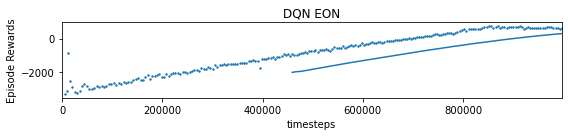

<Figure size 432x288 with 0 Axes>

In [39]:
#main function with callback

# Create and wrap the environment
nodeList, linkList = createTestTopology()
#changed to only have 1 request per episode
#from 6 originally
requestList = generateRequests(nodeList, 6)
user = User()


env = game_gym(nodeList, linkList, requestList, user)
check_env(env)

eveon = Monitor(env, log_tensorboard)

# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=10000, log_dir=log_tensorboard)

#hyperparameters testing
lr = 0.001
gamma = 0.7
eps_start = 1
eps_end = 0.15
train_freq = (2000, "step")
target_update_interval = 20000
policy_kwargs = {
    'net_arch':[64,64] #MLP hidden layer size
}


# Train the agent
#model = DQN('MlpPolicy', eveon, verbose=2, buffer_size=100)
model = DQN('MlpPolicy', eveon, learning_starts=10000, buffer_size=10000, verbose=1, device="auto", learning_rate=lr, gamma=gamma, exploration_fraction=0.85, exploration_initial_eps=eps_start, exploration_final_eps=eps_end, target_update_interval=target_update_interval, train_freq=train_freq, tensorboard_log="./tensorboard_logs/")
    

timesteps = int(1000000)
model.learn(total_timesteps=timesteps, tb_log_name="DQN_tensor", callback=callback)

# # Close the environment
# eveon.close()

# Plot rewards
plot_results([log_tensorboard], timesteps, results_plotter.X_TIMESTEPS, "DQN EON")
plt.show()
plt.savefig("episode rewards over timestamps.png")

In [ ]:
#torch.cuda.memory_summary(device=None, abbreviated=False)

In [ ]:
#to start tensorboard logging, select the --logdir where the logs are at (in this case tensorboard_logs)
%tensorboard --logdir tensorboard_logs

In [41]:
#model.save("DQNEveon_1mil_030322")

## More Rounds of training with updated rewards

(256, 256, 3)
Logging to ./tensorboard_logs/DQN_030322_2mil_1
1 link
1
2
1 link
1
2
2 links
2
3
1 link
1
2
2 links
2
3
2 links
2
5
2 links
2
7
more than 3 links
End episode, cumulative Reward:
-2793.9999999999777
(256, 256, 3)
1 link
1
2
more than 3 links
1 link
1
2
1 link
1
2
1 link
1
4
1 link
1
2
2 links
2
3
End episode, cumulative Reward:
-2971.79999999997
(256, 256, 3)
more than 3 links
Num timesteps: 10000
Best mean reward: 302.49 - Last mean reward per episode: 253.44
1 link
1
2
1 link
1
4
2 links
2
3
more than 3 links
2 links
2
3
2 links
2
5
2 links
2
7
2 links
2
3
2 links
2
5
2 links
2
7
2 links
2
9
1 link
1
10
1 link
1
12
1 link
1
2
more than 3 links
1 link
1
2
2 links
2
5
2 links
2
3
End episode, cumulative Reward:
-2333.8000000000065
(256, 256, 3)
1 link
1
2
2 links
2
3
1 link
1
2
2 links
2
3
1 link
1
2
1 link
1
4
1 link
1
2
2 links
2
3
2 links
2
5
more than 3 links
more than 3 links
End episode, cumulative Reward:
-2815.8999999999724
(256, 256, 3)
--------------------------

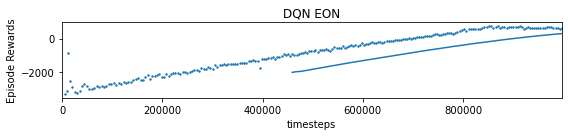

<Figure size 432x288 with 0 Axes>

In [60]:
timesteps = int(1000000)
model.learn(total_timesteps=timesteps, tb_log_name="DQN_030322_2mil", callback=callback)

# # Close the environment
# eveon.close()

# Plot rewards
plot_results([log_tensorboard], timesteps, results_plotter.X_TIMESTEPS, "DQN EON")
plt.show()
plt.savefig("episode rewards over timestamps_1.png")

In [61]:
#model.save("DQNEveon_2mil_030322")

In [8]:
# Create and wrap the environment
nodeList, linkList = createTestTopology()
#changed to only have 1 request per episode
#from 6 originally
requestList = generateRequests(nodeList, 6)
user = User()
timesteps = int(3000000)

env = game_gym(nodeList, linkList, requestList, user)
check_env(env)

eveon = Monitor(env, log_tensorboard)

# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=10000, log_dir=log_tensorboard)

6
(256, 256, 3)
Request Timed Out, cumulative Reward:
0
(256, 256, 3)


In [9]:
#had to load from save here
cont_model = DQN.load("DQNEveon_2mil_030322.zip", env=env, device="cuda")

cont_model.learn(total_timesteps=timesteps, tb_log_name="DQN_030322_3mil", callback=callback)

# # Close the environment
# eveon.close()

# Plot rewards
plot_results([log_tensorboard], timesteps, results_plotter.X_TIMESTEPS, "DQN EON")
plt.show()
plt.savefig("episode rewards over timestamps_2.png")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


D:\Programs\Anaconda\envs\RL\lib\site-packages\stable_baselines3\common\buffers.py:221: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 3.93GB > 1.96GB
  "This system does not have apparently enough memory to store the complete "


(256, 256, 3)
Logging to ./tensorboard_logs/DQN_030322_3mil_1
1 link
1
2
1 link
1
2
more than 3 links
2 links
2
5
2 links
2
7
2 links
2
3
1 link
1
2
2 links
2
3
2 links
2
3
1 link
1
2
2 links
2
3
2 links
2
5
more than 3 links
2 links
2
5
more than 3 links
2 links
2
5
2 links
2
7
2 links
2
9
2 links
2
3
2 links
2
3
2 links
2
5
more than 3 links
2 links
2
5
more than 3 links
more than 3 links
2 links
2
7
2 links
2
3
2 links
2
5
more than 3 links
more than 3 links
more than 3 links
more than 3 links
more than 3 links
more than 3 links
more than 3 links
more than 3 links
more than 3 links
more than 3 links
more than 3 links
2 links
2
9
2 links
2
11
2 links
2
3
2 links
2
5
2 links
2
7
more than 3 links
more than 3 links
2 links
2
5
End episode, cumulative Reward:
-4862.500000000005
(256, 256, 3)
1 link
1
2
1 link
1
2
1 link
1
4
1 link
1
2
2 links
2
3
2 links
2
5
more than 3 links
more than 3 links
more than 3 links
more than 3 links
more than 3 links
2 links
2
3
2 links
2
5
more than 3 link

IndexError: index -1 is out of bounds for axis 0 with size 0

<Figure size 576x144 with 0 Axes>

In [10]:
cont_model.save("DQNEveon_2+3mil_030322")

In [12]:
#MAIN FUNCTION
def main():

    nodeList, linkList = createTestTopology()

    #changed to only have 1 request per episode
    #from 6 originally
    requestList = generateRequests(nodeList, 6)

    user = User()
    eveon = game_gym(nodeList, linkList, requestList, user)

    check_env(eveon, warn=True)

    #hyperparameters testing
    lr = 0.001
    gamma = 0.77
    eps_start = 1
    eps_end = 0.15
    train_freq = (100, "step")
    target_update_interval = 2000
    policy_kwarg = {
        'net_arch': [64,64] #MLP hidden layer size
    }
    #learning_starts = 500 #memory warmup(?)


    #added additional hyperparameters to test the training
    #model = DQN('MlpPolicy', eveon, learning_rate=lr, verbose=1, buffer_size=100, device="auto", gamma=gamma, exploration_initial_eps=eps_start, exploration_final_eps=eps_end, exploration_fraction=1)
    
    #added new parameters to DQN model
    model = DQN('MlpPolicy', eveon, batch_size=32 ,buffer_size=450, verbose=1, device="auto", learning_rate=lr, gamma=gamma, exploration_fraction=0.85, exploration_initial_eps=eps_start, exploration_final_eps=eps_end, target_update_interval=target_update_interval, train_freq=train_freq)
    #for the model might want to change to CnnPolicy (used when DQN uses images as input)

    #added log for every 3000 timesteps
    model.learn(total_timesteps=1000000)
    
    '''
    for i in range(6):
        #for loop which increases the number of requests per training loop
        req_num = random.randint(1, i + 2)

        #generate requestlist for for loop
        requestList = generateRequests(nodeList, req_num)

        model.learn(total_timesteps=15000)
        
        #debug for training
        print("Model Trained with " + str(req_num) + " requests")
    '''
    
    
    model.save("DQNEveon_testing_260222")

    
    # THIS IS THE TESTING LOOP OF THE AGENT PLAYING THE GAME
    obs = eveon.reset()
    while True :
        action, states_ = model.predict(obs, deterministic=False)
        # action = 6
        obs, rewards, dones, info = eveon.step(action)
        
        print("Action:")
        print(action)
        #time.sleep(1)
        #clear_output(wait=True)


        if dones == True:
            #debug print
            print("########################Reward Obtained:")
            print(eveon.reward)
            # with open('info.json', 'w') as outfile:
            #     json.dump(info, outfile)

            eveon.reset()

        eveon.render()
    
    return model


In [ ]:
if __name__ == '__main__':
    model = main()

In [18]:
#test2 is the successful one (but still just spams enter key)
#LOADING MODEL FROM ZIP
#loaded_model = DQN.load("DQNEveon_test2")
#loaded_model = DQN.load("DQNEveon_testing_surface_250222")

#2mil timestep model load
#NOTE that old model on more complex game not compatible with new observation window
#loaded_model = DQN.load("DQNEveon_2mil_270222", device="cpu")
#best model load during 2mil training
#loaded_model = DQN.load("./Models/270222_Model_2mil/best_model.zip", device="cpu")

#loading 1mil semi simplified model with new rewards
#loaded_model = DQN.load("DQNEveon_1mil_030322.zip")
#loaded_model = DQN.load("DQNEveon_2mil_030322.zip")
loaded_model = DQN.load("DQNEveon_2+3mil_030322.zip")
#loaded_model = DQN.load("./Models/030322_Model_1mil_sofar/best_model.zip")

D:\Programs\Anaconda\envs\RL\lib\site-packages\stable_baselines3\common\buffers.py:221: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 3.93GB > 2.71GB
  "This system does not have apparently enough memory to store the complete "


# Testing Agent Performance

In [20]:
nodeList, linkList = createTestTopology()

#changed to only have 1 request per episode
#from 6 originally
requestList = generateRequests(nodeList, 1)

user = User()
eveon = game_gym(nodeList, linkList, requestList, user)

check_env(eveon, warn=True)

# THIS IS THE TESTING LOOP OF THE AGENT PLAYING THE GAME|
obs = eveon.reset()
while True :

    #enable this if using older models with the wider observation space
    #obs = cv2.resize(obs, dsize=(600, 1000))
    
    
    #trying to test if deterministic true or false changes model actions
    action, states_ = loaded_model.predict(obs, deterministic=False)
    # action = 6
    obs, rewards, dones, info = eveon.step(action)
    
    print("Action:")
    print(action)
    #time.sleep(1)
    #clear_output(wait=True)


    if dones == True:
        #debug print
        print("########################Reward Obtained:")
        print(eveon.reward)
        # with open('info.json', 'w') as outfile:
        #     json.dump(info, outfile)

        eveon.reset()

    eveon.render()

1
(256, 256, 3)
(256, 256, 3)
Action:
2
Action:
2
Action:
1
Action:
0
Action:
1
Action:
0
Action:
0
Action:
0
Action:
0
Action:
0
Action:
0
Action:
0
Action:
0
Action:
0
Action:
0
Action:
0
Action:
0
Action:
0
Action:
0
Action:
0
Action:
2
Action:
0
Action:
0
Action:
0
Action:
0
Action:
0
Action:
0
Action:
0
Action:
0
Action:
1
Action:
0
Action:
3
Action:
0
Action:
0
Action:
3
Action:
0
Action:
0
Action:
0
Action:
0
Action:
0
Action:
0
Action:
0
Action:
0
Action:
0
Action:
0
Action:
0
Action:
0
Action:
0
Action:
0
Action:
0
Action:
1
Action:
0
Action:
0
Action:
2
Action:
1
Action:
0
Action:
1
Action:
0
Action:
2
Action:
0
Action:
1
Action:
1
Action:
1
Action:
1
Action:
1
Action:
1
Action:
1
Action:
2
Action:
1
Action:
1
Action:
1
Action:
3
Action:
1
Action:
1
Action:
1
Action:
1
Action:
1
Action:
1
Action:
1
Action:
1
Action:
1
Action:
1
Action:
1
Action:
1
Action:
1
Action:
1
Action:
1
Action:
1
Action:
2
Action:
1
Action:
1
Action:
1
Action:
1
Action:
1
Action:
1
Action:
1
Action:
3


SystemExit: 

D:\Programs\Anaconda\envs\RL\lib\site-packages\IPython\core\interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Random Action Performance

In [11]:
#agent taking random actions
nodeList, linkList = createTestTopology()

#changed to only have 1 request per episode
#from 6 originally
requestList = generateRequests(nodeList, 6)

user = User()
eveon = game_gym(nodeList, linkList, requestList, user)

check_env(eveon, warn=True)
#resets the environment
obs = eveon.reset()

for step in range(2000):
	eveon.render()

	rand_action = eveon.action_space.sample()
	eveon.step(rand_action)
	print(rand_action)

env.close()

6
(1000, 600, 3)
(1000, 600, 3)
3
2
3
3
1
0
2
1
1
3
2
1
2
2
2
1
0
1
0
3
3
3
3
3
0
2
1
2
2
3
0
1
2
1
3
1
0
1
3
3
3
1
1
0
2
2
2
2
3
2
3
3
3
2
3
3
3
2
3
2
2
1
0
1
1
0
3
2
1
0
1
2
3
0
1
0
0
0
3
0
3
1
2
3
2
2
1
2
1
2
0
0
3
3
0
3
1
3
0
2
1
1
2
1
0
1
0
1
2
2
1
3
3
2
1
0
0
0
3
1
1
0
1
1
3
1
3
0
1
0
0
3
0
2
0
0
3
3
2
3
1
0
0
1
0
2
2
2
3
1
0
1
0
2
1
0
2
2
2
2
1
0
3
3
3
3
3
1
0
3
0
0
0
0
0
2
2
1
3
0
2
1
1
1
1
2
3
1
2
1
0
2
0
1
0
1
1
2
3
1
3
2
2
0
3
1
3
1
2
1
3
1
3
0
1
0
3
2
1
3
1
2
1
2
2
3
3
2
2
0
2
2
3
3
2
1
0
1
1
0
1
0
3
3
2
0
2
3
1
3
1
0
0
2
1
2
1
3
0
2
2
1
3
2
0
0
1
2
0
0
1
0
3
2
3
2
3
1
1
1
2
0
2
3
1
0
3
0
3
2
0
3
0
3
0
0
0
2
2
0
0
1
0
3
1
2
1
0
2
3
1
0
0
2
1
3
1
1
0
0
1
3
1
0
1
0
3
1
0
0
2
2
0
1
0
1
1
1
1
2
2
0
2
0
1
0
2
2
0
2
2
0
1
2
3
2
3
3
1
2
1
3
2
0
2
2
3
2
2
3
0
1
1
1
3
3
2
0
3
1
1
0
2
2
0
3
2
2
2
0
2
3
3
3
1
0
0
1
1
2
3
2
3
0
1
3
2
3
1
2
1
3
1
0
0
0
3
2
2
0
2
3
0
1
3
2
0
1
2
3
0
1
1
1
0
0
1
2
3
2
0
3
2
1
0
0
3
3
2
0
2
0
1
0
1
1
3
0
3
1
0
3
0
0
0
2
0
0
0
0
2
1
1
3
2
2
0
2
2
1
3
2
3
1


In [ ]:
#test main function
nodeList, linkList = createTestTopology()
requestList = generateRequests(nodeList, 6)

user = User()
eveon = game_gym(nodeList, linkList, requestList, user)

check_env(eveon, warn=True)

#defining the agent
model = DQN('MlpPolicy', eveon, verbose=1, buffer_size=100, device='cuda')

screen = eveon.render()
#storing episode_durations during training to plot them
#creating empty list to store
#adding plot to check the training process?
episode_durations = []
timestep = 0


#trying the double nested for loop

for episode in range(100):

#resets the environment
obs = eveon.reset()

#nested for loop iterate over time step
for timesetp in count():

    action, states_ = model.predict(obs, deterministic=True)
    # action = 6
    
    obs, rewards, dones, info = eveon.step(action)
    

    print(action)
    
    #this only runs when the agent actually competed the level
    if dones == True:
        #debug print
        print("########################Reward Obtained:")
        print(eveon.reward)

        episode_durations.append(timestep)
        plot(episode_durations, 100)
        
        # with open('info.json', 'w') as outfile:
        #     json.dump(info, outfile)
        timestep += 1
        eveon.reset()

    eveon.render()

    screen = eveon.render('rgb_array')
    plt.figure()
    plt.imshow(screen)
    plt.title('test screen')
    plt.show()